In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm


In [2]:

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9
# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Function to fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.05, 0, 0.1]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 0.5)]  # Reasonable bounds
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(data_grouped['delta_dur_adjusted'], data_grouped['chose_test'], data_grouped['response']),
        bounds=bounds
    )
    return result.x

# Bin delta durations
def bin_data(data, bins):
    data['delta_dur_bin'] = pd.cut(data['delta_dur_adjusted'], bins=bins, labels=False)
    binned_data = data.groupby('delta_dur_bin').agg(
        delta_dur_center=('delta_dur_adjusted', 'mean'),
        chose_test=('chose_test', 'sum'),
        total_responses=('response', 'count')
    ).reset_index()
    binned_data['p_chose_test'] = binned_data['chose_test'] / binned_data['total_responses']
    return binned_data

    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Function to fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.05, 0, 0.1]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 0.5)]  # Reasonable bounds
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(data_grouped['delta_dur_adjusted'], data_grouped['chose_test'], data_grouped['response']),
        bounds=bounds
    )
    return result.x


In [3]:

# Load data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)

# Display unique standard durations
print(f"Standard duration levels are: {np.unique(data['standard_dur'])}")

# Add chose_test column
data = data.assign(chose_test=(data['response'] == data['test_order']).astype(int))

# Group data by standard_dur and rise_dur
grouped_by_standard = data.groupby('standard_dur')


Standard duration levels are: [1.   1.25 1.5  1.75]



Fitting psychometric function for standard duration = 1.0s


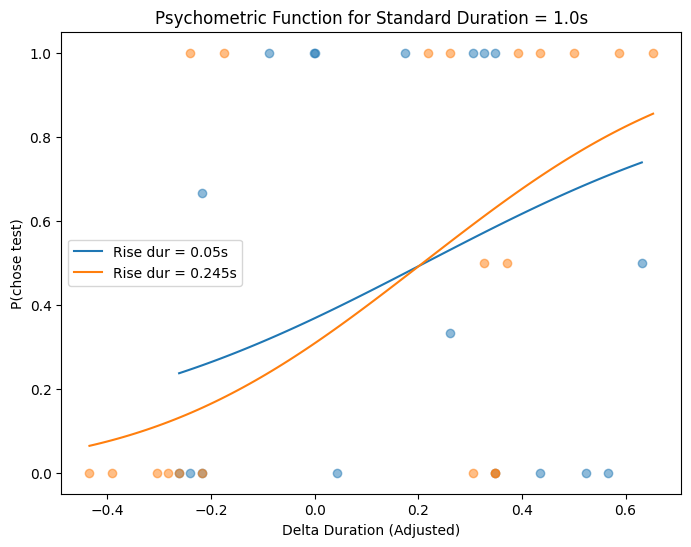


Fitting psychometric function for standard duration = 1.25s


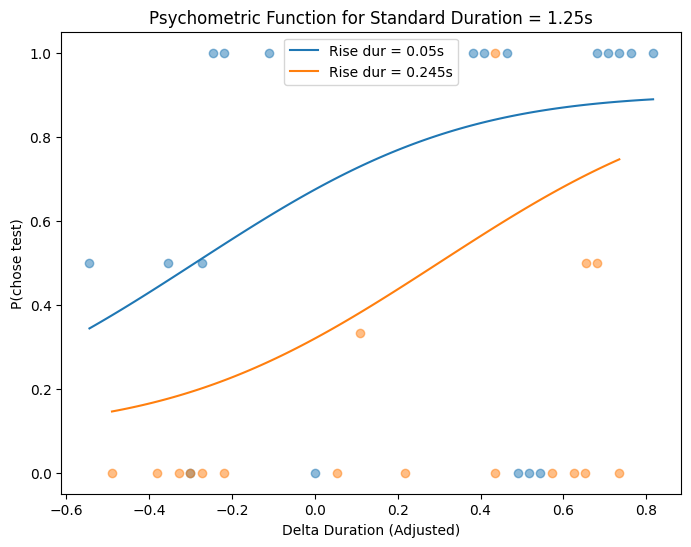


Fitting psychometric function for standard duration = 1.5s


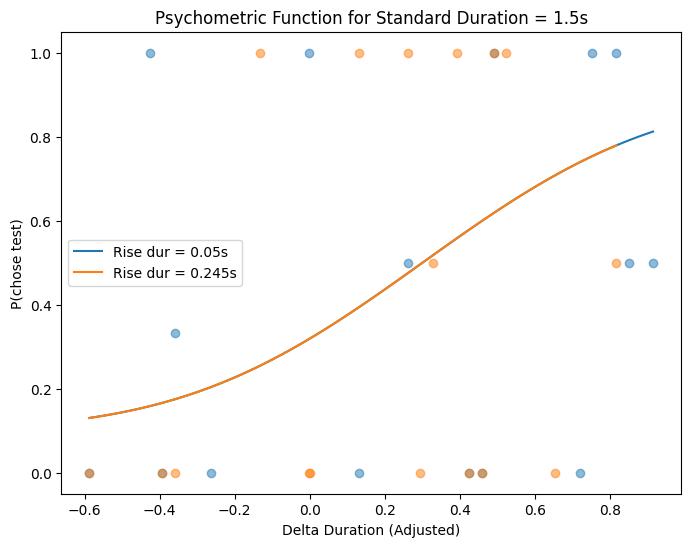


Fitting psychometric function for standard duration = 1.75s


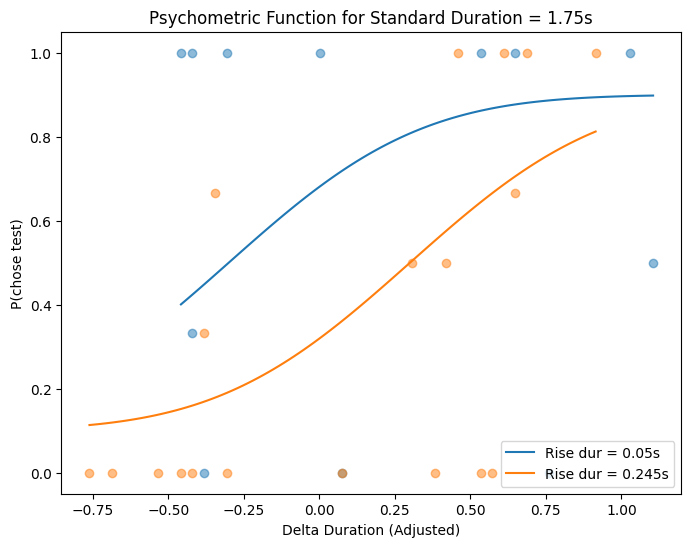

In [7]:
# Initialize storage for results
fit_results = {}
# Plot psychometric functions for each standard_dur
for standard_dur, group in grouped_by_standard:
    print(f"\nFitting psychometric function for standard duration = {standard_dur}s")
    grouped_by_rise_dur = group.groupby('rise_dur')

    plt.figure(figsize=(8, 6))
    for rise_dur, rise_group in grouped_by_rise_dur:
        # Group by delta_dur_adjusted and calculate proportions
        rise_group = rise_group.groupby('delta_dur_adjusted').agg(
            chose_test=('chose_test', 'sum'),
            response=('response', 'count')
        ).reset_index()

        # Fit psychometric function
        lambda_, mu, sigma = fit_psychometric_function(rise_group)

        # Store results
        fit_results[(standard_dur, rise_dur)] = {'lambda': lambda_, 'mu': mu, 'sigma': sigma}

        # Plot psychometric function
        intensities = np.linspace(rise_group['delta_dur_adjusted'].min(), rise_group['delta_dur_adjusted'].max(), 100)
        p_test = psychometric_function(intensities, lambda_, mu, sigma)
        plt.plot(intensities, p_test, label=f"Rise dur = {rise_dur}s")
        plt.scatter(rise_group['delta_dur_adjusted'], rise_group['chose_test'] / rise_group['response'], alpha=0.5)

    plt.xlabel('Delta Duration (Adjusted)')
    plt.ylabel('P(chose test)')
    plt.title(f'Psychometric Function for Standard Duration = {standard_dur}s')
    plt.legend()
    plt.show()



In [18]:
fit_results

{(1.0, 0.05): {'lambda': 0.2, 'mu': 0.21317329489987674, 'sigma': 0.5},
 (1.0, 0.245): {'lambda': 0.01,
  'mu': 0.20928454687310707,
  'sigma': 0.4134263339513346},
 (1.25, 0.05): {'lambda': 0.2, 'mu': -0.287743051614796, 'sigma': 0.5},
 (1.25, 0.245): {'lambda': 0.2, 'mu': 0.3, 'sigma': 0.5},
 (1.5, 0.05): {'lambda': 0.2, 'mu': 0.3, 'sigma': 0.5},
 (1.5, 0.245): {'lambda': 0.2, 'mu': 0.3, 'sigma': 0.5},
 (1.75, 0.05): {'lambda': 0.2, 'mu': -0.3, 'sigma': 0.5},
 (1.75, 0.245): {'lambda': 0.2, 'mu': 0.3, 'sigma': 0.5}}

In [5]:

# Display fit results
for (standard_dur, rise_dur), params in fit_results.items():
    print(f"Standard Dur: {standard_dur}s, Rise Dur: {rise_dur}s -- λ: {params['lambda']:.3f}, μ: {params['mu']:.3f}, σ: {params['sigma']:.3f}")


Standard Dur: 1.0s, Rise Dur: 0.05s -- λ: 0.200, μ: 0.213, σ: 0.500
Standard Dur: 1.0s, Rise Dur: 0.245s -- λ: 0.010, μ: 0.209, σ: 0.413
Standard Dur: 1.25s, Rise Dur: 0.05s -- λ: 0.200, μ: -0.288, σ: 0.500
Standard Dur: 1.25s, Rise Dur: 0.245s -- λ: 0.200, μ: 0.300, σ: 0.500
Standard Dur: 1.5s, Rise Dur: 0.05s -- λ: 0.200, μ: 0.300, σ: 0.500
Standard Dur: 1.5s, Rise Dur: 0.245s -- λ: 0.200, μ: 0.300, σ: 0.500
Standard Dur: 1.75s, Rise Dur: 0.05s -- λ: 0.200, μ: -0.300, σ: 0.500
Standard Dur: 1.75s, Rise Dur: 0.245s -- λ: 0.200, μ: 0.300, σ: 0.500


Standard duration levels are: [1.   1.25 1.5  1.75]

Fitting psychometric function for standard duration = 1.0s


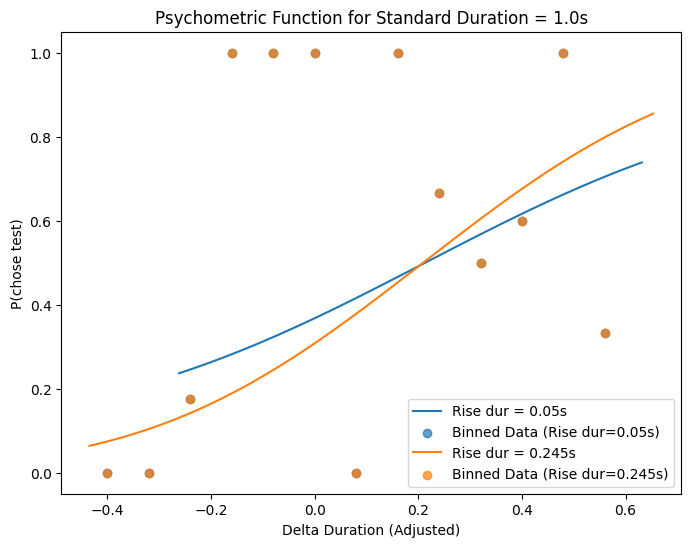


Fitting psychometric function for standard duration = 1.25s


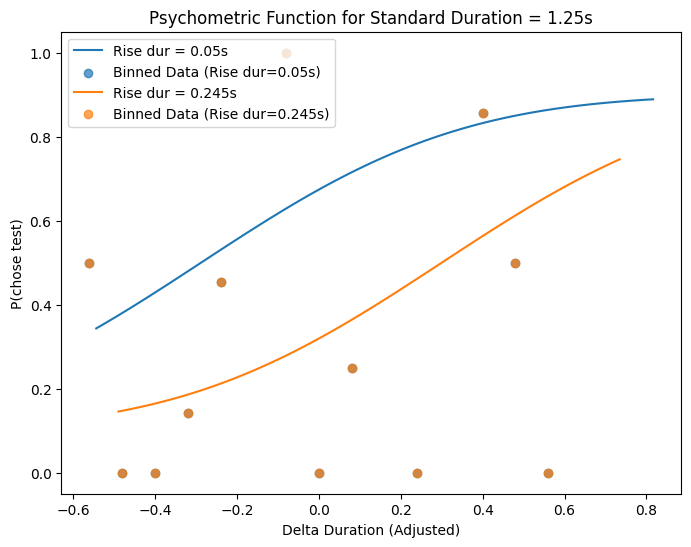


Fitting psychometric function for standard duration = 1.5s


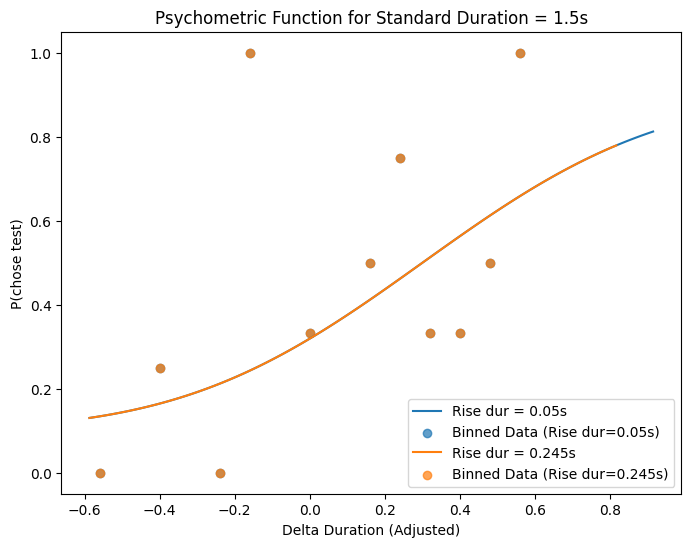


Fitting psychometric function for standard duration = 1.75s


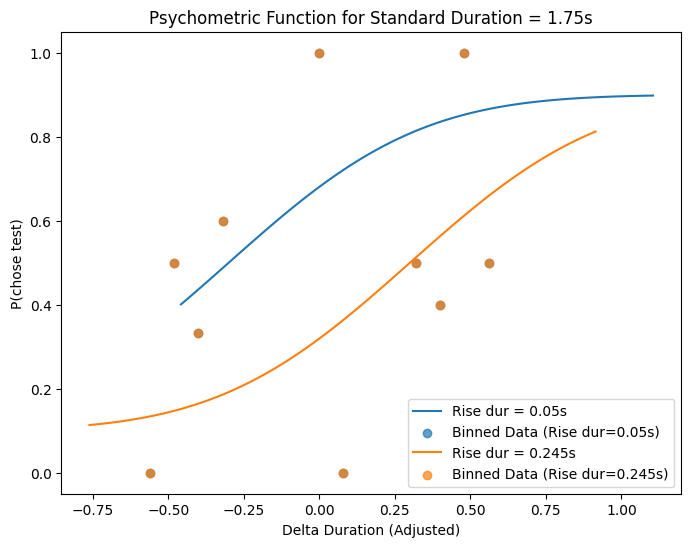

Standard Dur: 1.0s, Rise Dur: 0.05s -- λ: 0.200, μ: 0.213, σ: 0.500
Standard Dur: 1.0s, Rise Dur: 0.245s -- λ: 0.010, μ: 0.209, σ: 0.413
Standard Dur: 1.25s, Rise Dur: 0.05s -- λ: 0.200, μ: -0.288, σ: 0.500
Standard Dur: 1.25s, Rise Dur: 0.245s -- λ: 0.200, μ: 0.300, σ: 0.500
Standard Dur: 1.5s, Rise Dur: 0.05s -- λ: 0.200, μ: 0.300, σ: 0.500
Standard Dur: 1.5s, Rise Dur: 0.245s -- λ: 0.200, μ: 0.300, σ: 0.500
Standard Dur: 1.75s, Rise Dur: 0.05s -- λ: 0.200, μ: -0.300, σ: 0.500
Standard Dur: 1.75s, Rise Dur: 0.245s -- λ: 0.200, μ: 0.300, σ: 0.500


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# Psychometric function
def psychometric_function(intensities, lapse_rate, mu, sigma):
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood

# Function to fit psychometric function
def fit_psychometric_function(data_grouped):
    initial_guess = [0.05, 0, 0.1]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0.01, 0.2), (-0.3, 0.3), (0.01, 0.5)]  # Reasonable bounds
    result = minimize(
        negative_log_likelihood, initial_guess, 
        args=(data_grouped['delta_dur_adjusted'], data_grouped['chose_test'], data_grouped['response']),
        bounds=bounds
    )
    return result.x

# Function to calculate binned data for plotting
def bin_data(data, bin_edges):
    data['delta_dur_bin'] = pd.cut(data['delta_dur_adjusted'], bins=bin_edges)
    binned_data = data.groupby('delta_dur_bin',observed=False).agg(
        binned_chose_test=('chose_test', 'sum'),
        binned_total_responses=('response', 'count')
    ).reset_index()
    # Calculate binned probabilities
    binned_data['p_chose_test'] = binned_data['binned_chose_test'] / binned_data['binned_total_responses']
    # Get bin centers for plotting
    binned_data['bin_center'] = binned_data['delta_dur_bin'].apply(lambda x: x.mid)
    return binned_data

# Load data
file_path = 'data/'+'_auditory_dur_estimate_2024-12-19_01h06.07.475.csv'
data = pd.read_csv(file_path)

# Display unique standard durations
print(f"Standard duration levels are: {np.unique(data['standard_dur'])}")

# Add chose_test column
data = data.assign(chose_test=(data['response'] == data['test_order']).astype(int))

# Define bins for plotting (example: 15 bins between -0.6 and 0.6)
bin_edges = np.linspace(-0.6, 0.6, 16)

# Group data by standard_dur and rise_dur
grouped_by_standard = data.groupby('standard_dur')

# Initialize storage for results
fit_results = {}

# Plot psychometric functions for each standard_dur
for standard_dur, group in grouped_by_standard:
    print(f"\nFitting psychometric function for standard duration = {standard_dur}s")
    grouped_by_rise_dur = group.groupby('rise_dur')

    plt.figure(figsize=(8, 6))
    for rise_dur, rise_group in grouped_by_rise_dur:
        # Fit psychometric function to unbinned data
        rise_group = rise_group.groupby('delta_dur_adjusted',observed=False).agg(
            chose_test=('chose_test', 'sum'),
            response=('response', 'count')
        ).reset_index()
        lambda_, mu, sigma = fit_psychometric_function(rise_group)

        # Store results
        fit_results[(standard_dur, rise_dur)] = {'lambda': lambda_, 'mu': mu, 'sigma': sigma}

        # Plot psychometric function
        intensities = np.linspace(rise_group['delta_dur_adjusted'].min(), rise_group['delta_dur_adjusted'].max(), 100)
        p_test = psychometric_function(intensities, lambda_, mu, sigma)
        plt.plot(intensities, p_test, label=f"Rise dur = {rise_dur}s")

        # Calculate binned data for plotting
        binned_data = bin_data(group, bin_edges)
        plt.scatter(binned_data['bin_center'], binned_data['p_chose_test'], label=f'Binned Data (Rise dur={rise_dur}s)', alpha=0.7)

    plt.xlabel('Delta Duration (Adjusted)')
    plt.ylabel('P(chose test)')
    plt.title(f'Psychometric Function for Standard Duration = {standard_dur}s')
    plt.legend()
    plt.show()

# Display fit results
for (standard_dur, rise_dur), params in fit_results.items():
    print(f"Standard Dur: {standard_dur}s, Rise Dur: {rise_dur}s -- λ: {params['lambda']:.3f}, μ: {params['mu']:.3f}, σ: {params['sigma']:.3f}")
